In [1]:
#!/usr/bin/env python3

"""Samples from k-diffusion models."""

import argparse
import math

import accelerate
import torch
from tqdm import tqdm

import k_diffusion as K
from condition.condition import ConditionImageDenoiserV2
from condition.measurements import get_operator

from torch.utils import data
from torchvision import datasets, transforms, utils

import yaml
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import lpips
import os
from functools import partial


def load_yaml(file_path: str) -> dict:
    with open(file_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    return config


def save_yaml(data: dict, file_path: str):
    with open(file_path, 'w') as file:
        yaml.dump(data, file)


def compute_metrics(hat_x0, x0, loss_fn_vgg):
    def to_eval(x: torch.Tensor):
        return (x[0] / 2 + 0.5).clip(0, 1).detach()
    psnr = peak_signal_noise_ratio(to_eval(x0).cpu().numpy(), to_eval(hat_x0).cpu().numpy(), data_range=1).item()
    ssim = structural_similarity(to_eval(x0).cpu().numpy(), to_eval(hat_x0).cpu().numpy(), channel_axis=0, data_range=1).item()
    lpips = loss_fn_vgg(to_eval(x0), to_eval(hat_x0))[0, 0, 0, 0].item()
    metrics = {'psnr': psnr, 'ssim': ssim, 'lpips': lpips}
    print(metrics)
    return metrics


def calculate_average_metric(metrics_list):
    avg_dict = {}
    count_dict = {}

    for metrics in metrics_list:
        for key, value in metrics.items():
            if key not in avg_dict:
                avg_dict[key] = 0.0
                count_dict[key] = 0
            avg_dict[key] += value
            count_dict[key] += 1

    for key in avg_dict:
        if count_dict[key] > 0:
            avg_dict[key] /= count_dict[key]

    return avg_dict


def to_show(x: torch.Tensor, ref=None):
    x = x[0].permute(1, 2, 0)

    if ref is None:
        x_min, x_max = x.min(), x.max()
    else:
        x_min, x_max = ref.min(), ref.max()
        
    x = (x - x_min) / (x_max - x_min)

    return x.detach().cpu().numpy()


class Args:
    def __init__(self) -> None:
        self.batch_size = 1
        self.config = "configs/train_ffhq_dct.json"
        self.checkpoint = "ffhq_dct_04380000.pth"


args = Args()


assert args.batch_size == 1

torch.backends.cuda.matmul.allow_tf32 = True

config = K.config.load_config(open(args.config))
model_config = config['model']
dataset_config = config['dataset']

# TODO: allow non-square input sizes
assert len(model_config['input_size']) == 2 and model_config['input_size'][0] == model_config['input_size'][1]
size = model_config['input_size']

accelerator = accelerate.Accelerator()
device = accelerator.device
print(f'Using device: {device}', flush=True)

inner_model = K.config.make_model(config)
model = K.config.make_denoiser_wrapper(config)(inner_model)
ckpt = torch.load(args.checkpoint, map_location='cpu')
accelerator.unwrap_model(model.inner_model).load_state_dict(ckpt['model'])

# test data
tf = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x * 2 - 1
])
test_set = K.utils.FolderOfImages(dataset_config['location'], transform=tf)
test_dl = data.DataLoader(test_set, args.batch_size)

test_dl, model = accelerator.prepare(test_dl, model)
test_dl = iter(test_dl)


Using device: cpu


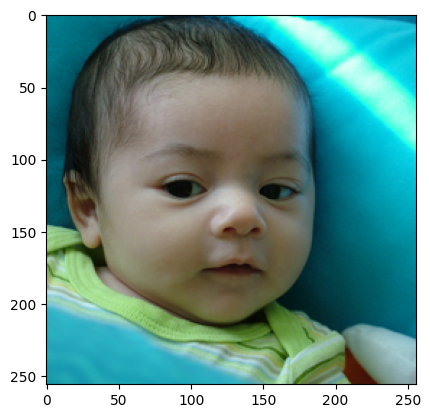

In [2]:
import matplotlib.pyplot as plt

x0, = next(test_dl)
plt.imshow(to_show(x0))

0.012651287019252777 0.0006294921622611582
0.0151316337287426 0.00013230335025582463
0.012651285156607628 0.01258048228919506
0.021012507379055023 0.01889861561357975


Text(0.5, 1.0, 'DCT Variance')

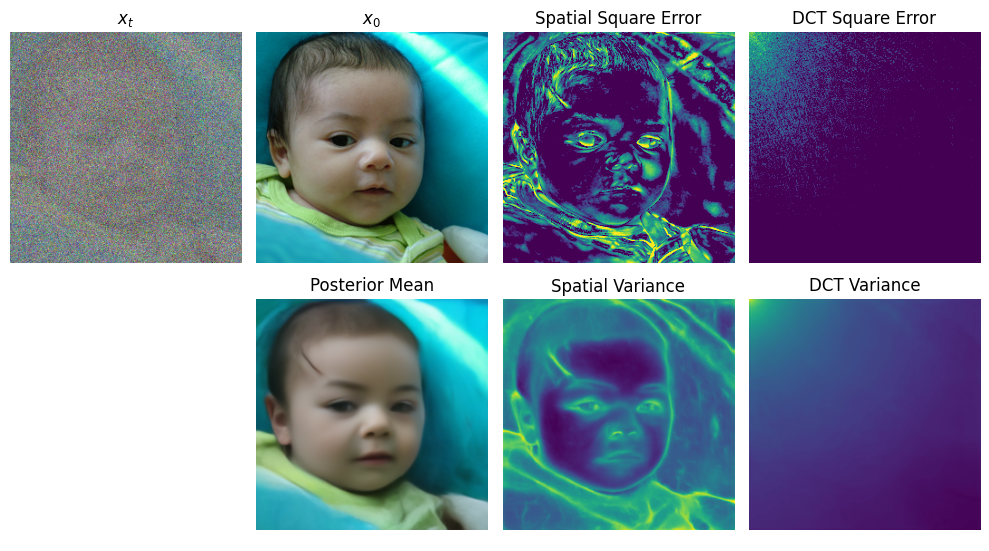

In [4]:
from torch.autograd import grad

sigma_min = model_config['sigma_min']
sigma_max = model_config['sigma_max']
sigmas = K.sampling.get_sigmas_karras(50, sigma_min, sigma_max, rho=7., device=device)
x0 = x0.to(device)

sigma = torch.Tensor([2]).to(device)
x = x0 + torch.randn_like(x0) * sigma
x = x.requires_grad_()

model_output, logvar, logvar_ot = model(x, sigma, return_variance=True)
c_skip, c_out, c_in = model.get_scalings(sigma)
ot = model.ortho_tf

x0_mean = model_output * c_out + x * c_skip

error = (x0_mean - x0).pow(2).mean(dim=1, keepdim=True)
error_pred = (logvar.exp() * c_out.pow(2)).mean(dim=1, keepdim=True)

error_ot = (ot(x0_mean) - ot(x0)).pow(2).mean(dim=1, keepdim=True)
error_ot_pred = (logvar_ot.exp() * c_out.pow(2)).mean(dim=1, keepdim=True)

print(error.mean().item(), error.var().item())
print(error_pred.mean().item(), error_pred.var().item())

print(error_ot.mean().item(), error_ot.var().item())
print(error_ot_pred.mean().item(), error_ot_pred.var().item())


fig, axes = plt.subplots(2, 4, figsize=(10, 5.5))
for ax in axes.flatten():
    ax.axis('off')
plt.tight_layout()

axes[0, 0].imshow(to_show(x), vmin=0, vmax=1)
axes[0, 0].set_title(rf"$x_t$")

axes[0, 1].imshow(to_show(x0))
axes[0, 1].set_title(rf"$x_0$")

axes[1, 1].imshow(to_show(x0_mean))
axes[1, 1].set_title(rf"Posterior Mean")

axes[0, 2].imshow(to_show(error.log(), ref=error_pred.log()), vmin=0, vmax=1)
axes[0, 2].set_title(rf"Spatial Square Error")

axes[1, 2].imshow(to_show(error_pred.log()), vmin=0, vmax=1)
axes[1, 2].set_title(rf"Spatial Variance")

axes[0, 3].imshow(to_show(error_ot.log(), ref=error_ot_pred.log()), vmin=0, vmax=1)
axes[0, 3].set_title(rf"DCT Square Error")

axes[1, 3].imshow(to_show(error_ot_pred.log()), vmin=0, vmax=1)
axes[1, 3].set_title(rf"DCT Variance")
